In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
sns.set_style('darkgrid')
%matplotlib inline

## Prendi i files, e 2 dataframes: df_dev e df_coord

In [34]:
def Aggrega_files():
    '''
    Prende tutti i CSV dalla dir corrente, distingue tra coordinates e devices e li aggrega in 2 
    dataframes. Quindi in uscita ho 2 dataframes, uno per i csv chiamati "devices" ed un altro per i
    csv chiamati "coordinates"
    '''
    Lista_files=os.listdir() #Mette in lista tutti i file csv che trova
    Lista_files=[el for el in Lista_files if el.split('.')[1]=='csv'] #Prende solo i csv files
    Lista_coord=[el for el in Lista_files if 'coord' in el]
    Lista_dev=[el for el in Lista_files if 'dev' in el]
    #Unisce tutti i csv insieme
    df_dev=list()
    for el in Lista_dev:
        df_dev.append(pd.read_csv(el,low_memory=False))
    df_dev=pd.concat(df_dev)

    #Unisce tutti i csv insieme
    df_coord=list()
    for el in Lista_coord:
        df_coord.append(pd.read_csv(el,low_memory=False))
    df_coord=pd.concat(df_coord)
    return(df_dev,df_coord)

def Fix_DateTime(df):
    df['timestamp2']=pd.to_datetime(df['timestamp'], unit='ms')
    #Separa data da tempo (crea due colonne)
    df['date'] = df['timestamp2'].dt.date
    df['time'] = df['timestamp2'].dt.time
    df['year']=df['date'].apply(lambda x: x.year)
    df['month']=df['date'].apply(lambda x: x.month)
    df['day']=df['date'].apply(lambda x: x.day)
    df['hour']=df['time'].apply(lambda x: x.hour)
    df['min']=df['time'].apply(lambda x: x.minute)
    df['msec']=df['time'].apply(lambda x: x.microsecond/1000)
    df_dev['DayOfWeek']=df_dev['date'].apply(lambda x: x.weekday())
    return(df)

## Preprocessing

In [35]:
#Componi due dataframe dai singoli files
(df_dev,df_coord)=Aggrega_files()
df_dev=Fix_DateTime(df_dev)
df_coord=Fix_DateTime(df_coord)

## Visione Generale
Informazioni sul dataset

In [59]:
print('Data di partenza:{},{}'.format(df_dev['date'].min(),df_dev['date'].weekday))
print('Data di fine:{}'.format(df_dev['date'].max()))
print('Durata in giorni:{}'.format(df_dev['date'].max()-df_dev['date'].min()))
print('Numero di righe:{}'.format(df_dev.shape[0]))

AttributeError: 'Series' object has no attribute 'weekday'

Calcoliamo il numero di devices unici che passano ogni giorno per il periodo considerato 

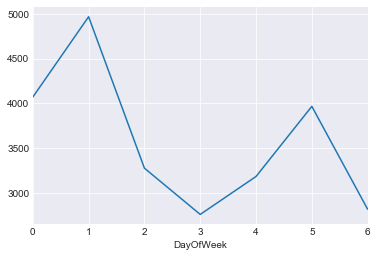

In [47]:
Num_unique_dev=df_dev.groupby('DayOfWeek').nunique()['deviceId'].plot()

In [15]:
g=df_dev.groupby('hour').nunique()['deviceId']

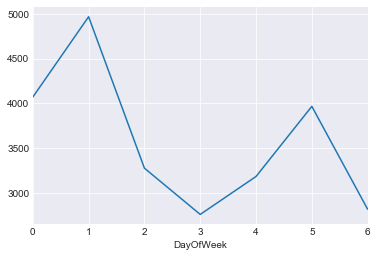

In [45]:
g2.plot()

AttributeError: 'FacetGrid' object has no attribute 'plot'

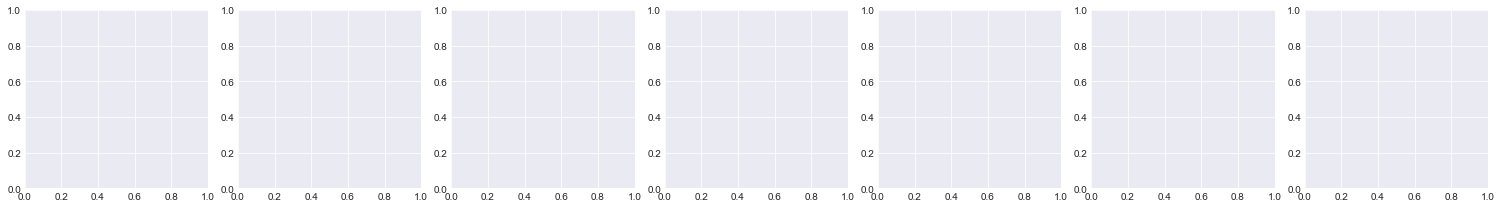

In [38]:
g=sns.FacetGrid(df_dev,col='DayOfWeek')
g.map(plt.scatter, "total_bill", "tip").add_legend()